### This notebook focuses on data preprocessing 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv("EasyVisa.csv")
print(df.shape)
df.head()

(25480, 12)


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


#### Check for any NaN values

In [3]:
df.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

#### Check for duplicates

In [4]:
df[df.duplicated()]

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status


#### We can remove the case_id as we inferred from EDA 

In [5]:
df = df.drop(columns=['case_id'],axis=1)

### Feature Engineering

In [6]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [7]:
from datetime import date

curr_date = date.today()
curr_year = curr_date.year

print("date:",curr_date)
print("year:",curr_year)

date: 2026-01-13
year: 2026


In [8]:
df['company_age'] = curr_year - df['yr_of_estab']
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,19
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,24
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,18
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,129
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,21


In [9]:
df.drop(columns='yr_of_estab',axis=1,inplace=True)

#### Types of features

In [10]:
num_features = list(df.select_dtypes(include=[np.number]).columns)
print(num_features)
print("Number of numerical features:",len(num_features))

['no_of_employees', 'prevailing_wage', 'company_age']
Number of numerical features: 3


In [11]:
cat_features = list(df.select_dtypes(include=object).columns)
print(cat_features)
print("Number of categorical features:",len(cat_features))

['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']
Number of categorical features: 8


In [12]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 0


In [13]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 3


In [14]:
X = df.drop('case_status',axis=1)
y = df[['case_status']]

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first',sparse_output=False)
y = ohe.fit_transform(y) 
# we one hot encoded the target denied:1,certified:0

In [16]:
y = y.ravel()
y

array([1., 0., 1., ..., 0., 0., 0.], shape=(25480,))

### Feature Transformation

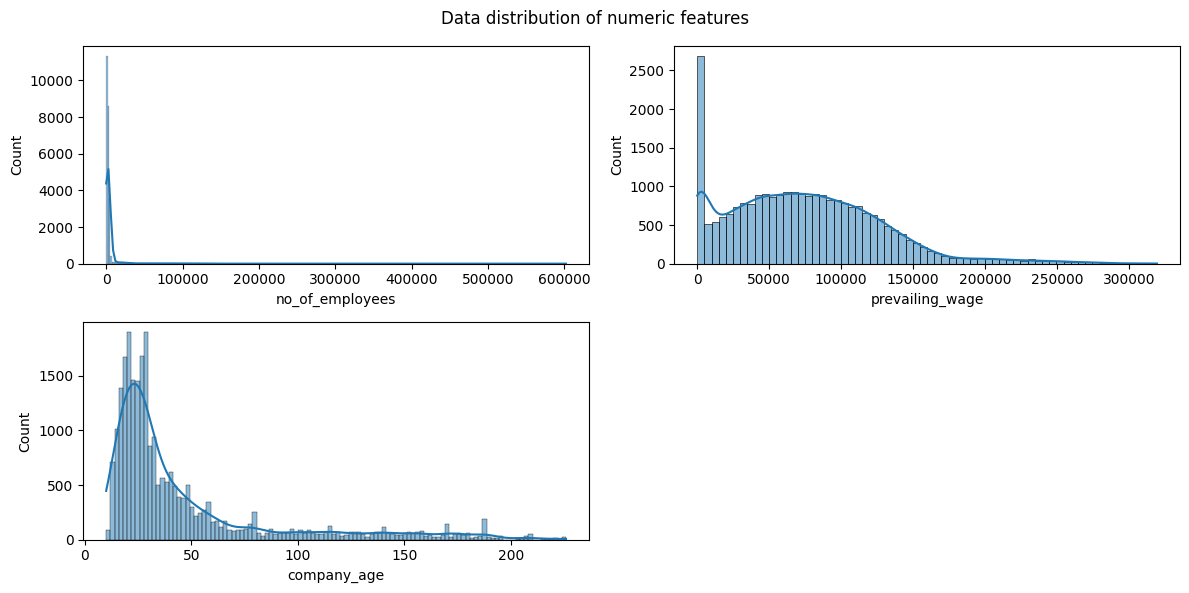

In [17]:
fig,axes = plt.subplots(2,2,figsize=(12,6))
axes = axes.flatten()

plt.suptitle("Data distribution of numeric features")

for i,col in enumerate(num_features):
    sns.histplot(data=X,x=col,kde=True,ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(len(num_features),len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

all numeric features are heavy tailed and right skewed 

In [18]:
X[continuous_features].skew(axis=0,skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

**Note**: Transforming the prevailing_wage still makes it skewed whether we use log transform or power transform  

We will check whether log transform or power transform works better for addressing the skewness

#### Log transform

In [19]:
X[['no_of_employees','company_age']].apply(np.log1p).skew(axis=0,skipna=True)

no_of_employees    0.156309
company_age        0.874455
dtype: float64

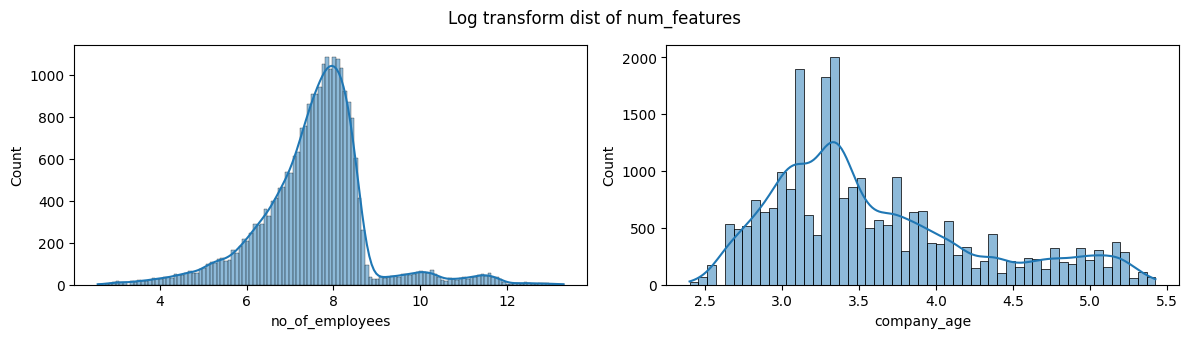

In [20]:
X_log = X.copy()
X_log = X_log[['no_of_employees','company_age']].apply(np.log1p)
num_features = len(continuous_features)

fig,axes = plt.subplots(2,2,figsize=(12,6))
axes = axes.flatten()

plt.suptitle("Log transform dist of num_features")

for i,col in enumerate(['no_of_employees','company_age']):
    sns.histplot(X_log[col],ax=axes[i],kde=True)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(len(['no_of_employees','company_age']), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- `no_of_employees` is distributed normally
- `prevailing_wage` is left_skewed
- `company_age` becomes a multimodal dist

#### Power Transform

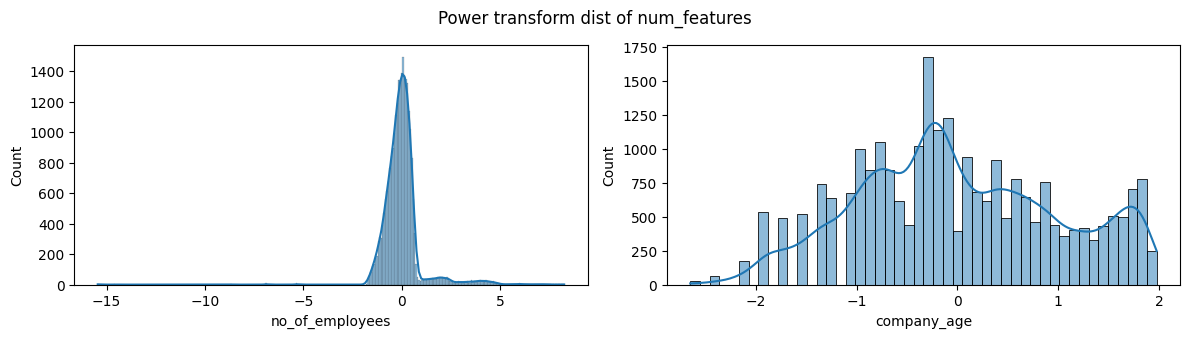

In [21]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
X_pt = X[['no_of_employees','company_age']].copy()
X_pt = pt.fit_transform(X_pt)

X_pt_df = pd.DataFrame(data=X_pt,columns=X[['no_of_employees','company_age']].columns,index=X[continuous_features].index)
fig,axes = plt.subplots(2,2,figsize=(12,6))
axes = axes.flatten()

plt.suptitle("Power transform dist of num_features")

for i,col in enumerate(['no_of_employees','company_age']):
    sns.histplot(X_pt_df[col],ax=axes[i],kde=True)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(len(['no_of_employees','company_age']), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- `no_of_employees` almost looks normally distributed
- `company_age` follows a multimodal distribution

In [22]:
X_pt_df.skew(axis=0, skipna=True)


no_of_employees    0.399339
company_age        0.120823
dtype: float64

#### Find the unique values in categorial features

In [23]:
df[cat_features].nunique()

continent                6
education_of_employee    4
has_job_experience       2
requires_job_training    2
region_of_employment     5
unit_of_wage             4
full_time_position       2
case_status              2
dtype: int64

### Feature Encoding and Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,PowerTransformer
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

ord_cols = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
ohe_cols = ['continent','unit_of_wage','region_of_employment']
pow_transform_cols= ['no_of_employees','company_age']
scale_cols = ['prevailing_wage']


preprocessor = ColumnTransformer([
        ("ohe", OneHotEncoder(drop='first', sparse_output=False), ohe_cols),
        ("ord", OrdinalEncoder(), ord_cols),
        ("pt", PowerTransformer(method='yeo-johnson'), pow_transform_cols),
        ("scaler", StandardScaler(), scale_cols)],remainder='drop')


In [25]:
X.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,19
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,24
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,18
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,129
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,21


In [26]:
X = preprocessor.fit_transform(X)
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.51729976,
        -0.95850606, -1.39853722],
       [ 1.        ,  0.        ,  0.        , ...,  0.03091211,
        -0.47081563,  0.1698353 ],
       [ 1.        ,  0.        ,  0.        , ...,  2.88507604,
        -1.08047911,  0.91907852],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.41388512,
         1.552921  ,  1.36027953],
       [ 1.        ,  0.        ,  0.        , ..., -0.11194883,
         1.68577154,  0.22150859],
       [ 1.        ,  0.        ,  0.        , ...,  0.21874168,
         1.03193665, -0.06776315]], shape=(25480, 19))